## Imports

In [103]:
#import copy
import json
import math
#import pprint
import random
#import scipy
import sklearn
#import statistics
import matplotlib.pyplot as plt
import numpy
import random
from scipy.stats import beta
from scipy.optimize import least_squares
from scipy.integrate import quad
from sklearn.metrics import r2_score

## Data loading and preprocessing

In [2]:
ranked_data_path = f"export.json"
ranked_data_file = open(ranked_data_path,encoding="utf-8")
ranked_data = json.load(ranked_data_file)

In [3]:
players = ranked_data["Players"]
maps = ranked_data["Maps"]
scores = ranked_data["Scores"]

In [4]:
min_score = 0.7
filtered_scores = [score for score in scores if score["Accuracy"] > min_score and score["Accuracy"] < 1.0 and score["Modifiers"] == ""]
print(len(scores))
print(len(filtered_scores))
print(len(filtered_scores)/len(scores))

3058785
2656447
0.8684647662388825


In [5]:
players_by_id = {player["Id"] : player for player in players}
maps_by_id = {bmap["Id"] : bmap for bmap in maps}

In [17]:
scores_by_player_id = {}
scores_by_map_id = {}
score_data_by_map_id = {}

def add_score(score):
    player_id = score["PlayerId"]
    map_id = score["LeaderboardId"]
    
    player_map = scores_by_player_id.get(player_id,{})
    player_map[map_id] = score
    
    scores_by_player_id[player_id] = player_map    


    
    map_map = scores_by_map_id.get(map_id,{})
    map_map[player_id] = score
    
    scores_by_map_id[map_id] = map_map   


    
    score_data = score_data_by_map_id.get(map_id,[])

    score_data.append(score["Accuracy"])

    score_data.sort()

    score_data_by_map_id[map_id] = score_data

for score in filtered_scores:
    add_score(score)

## Fitting a map's scores to a beta distribution

In [7]:
def fit_scores_beta(scores):
    (a, b, loc, scale) = beta.fit(scores, floc=0, fscale=1)
    return (a,b)

beta_parameters_per_map = {}

for map_id,scores in score_data_by_map_id.items():
    beta_parameters_per_map[map_id] = fit_scores_beta(scores)

In [18]:
# Using least squares
# Some help from ChatGPT used here (adapted)
def residuals(params, scores):   
    empirical_cdf = numpy.arange(1, len(scores) + 1) / len(scores)
    
    a, b = params
    model_cdf = beta.cdf(scores, a, b)
    return model_cdf - empirical_cdf

def fit_scores_beta_least_squares(scores, initial_params):
    residuals_lambda = lambda params:residuals(params,scores)
    
    result = least_squares(residuals_lambda, initial_params)
    
    return result.x

least_squares_beta_parameters_per_map = {}

for map_id,scores in score_data_by_map_id.items():
    initial_params = beta_parameters_per_map[map_id]

    least_squares_beta_parameters_per_map[map_id] = fit_scores_beta_least_squares(scores, initial_params)

In [28]:
def residuals_affine(params, scores):
    empirical_cdf = numpy.arange(1, len(scores) + 1) / len(scores)
    
    a, b, pass_threshold, testing_capability = params    
    
    model_cdf = pass_threshold + (testing_capability-pass_threshold)*beta.cdf(scores, a, b)
    return model_cdf - empirical_cdf

def fit_scores_beta_least_squares_affine(scores, initial_params):
    residuals_lambda = lambda params:residuals_affine(params,scores)

    bounds = ([0,0,0,0],[numpy.inf,numpy.inf,1,1])
    result = least_squares(residuals_lambda, initial_params, bounds=bounds)
    
    return result.x

In [179]:
min_a = 0
max_a = 150
min_b = 0
max_b = 10

# scores should be an array of pairs, where the first element of each pair is the score, the second is the skill of the player
def residuals_affine_skills(params, scores):
    skills = numpy.array([score[1] for score in scores])    
    sscores = numpy.array([score[0] for score in scores])    
    
    a, b, pass_threshold, testing_capability = params    
    
    predicted = pass_threshold + (testing_capability-pass_threshold)*beta.cdf(sscores, a, b)    
    return skills-predicted

def fit_scores_beta_least_squares_affine_skills(scores, initial_params):
    residuals_lambda = lambda params:residuals_affine_skills(params,scores)

    bounds = ([min_a,min_b,0,0],[max_a,max_b,1,1])
    result = least_squares(residuals_lambda, initial_params, bounds=bounds)
    
    return result.x

## Birating algorithm to estimate parameters by mutual iteration

In [ ]:
# TODO: Generalize this to be able to work with complex parameters and complex steps in each case.

class BiRating:
    """No description yet"""
    
    def __init__(self,
                 anodes_params,bnodes_params,
                 wdata,afun,bfun,wfun,
                 aggregation_fun=aggregation_median,
                 default_rating=1,
                 max_iter=50,
                 error_fun=abs_error,
                 error_aggregation_fun=aggregation_bottomscores,
                 finish_early=True,
                 error_change_prop=0.001):
        """
        anodes_params and bnodes_params must be dictionaries with the node identifiers as keys
        and initial parameters as values.
        
        wdata must be a doubly indexed dictionary with anode identifiers and bnode identifiers as respective indexes,
        respectively, and weights as values.
        
        afun and bfun must be functions taking a value of the other node type as first argument
        and a weight as the second argument, that returns the corresponding value for the node.
        
        Similarly, wfun must be a function that takes the value of an anode and bnode and returns the
        correct weight.
        
        These functions must be such that:
        - wfun(afun(b,w),b) = w
        - wfun(a,bfun(a,w)) = w
        - afun(bfun(a,w),w) = a
        - afun(b,wfun(a,b)) = a
        - bfun(afun(b,w),w) = b
        - bfun(a,wfun(a,b)) = b
        
        error_fun must take two parameters (actual value, expected value) and return a number indicating the error for that
        particular edge
        """
        self.anodes_ratings = anodes_ratings
        self.bnodes_ratings = bnodes_ratings
        
        self.adata = wdata
        self.bdata = self.process_bdata(wdata)
        
        self.afun = afun
        self.bfun = bfun
        self.wfun = wfun
        
        self.aggregation_fun = aggregation_fun
        
        self.error_fun = error_fun
        self.error_aggregation_fun = error_aggregation_fun
        
        self.default_rating = default_rating
        
        self.average_error = math.inf
        
        self.iter = 0
        self.max_iter = max_iter
        
        # Finish early when error increases
        self.finish_early = finish_early
        self.last_average_error = math.inf
        self.last_anodes_ratings = anodes_ratings
        self.last_bnodes_ratings = bnodes_ratings       
    
        self.error_change_prop = error_change_prop
    
    def process_bdata(self, wdata):
        bdata = {}
        
        for anode_id, anode_data in wdata.items():
            for bnode_id, w in anode_data.items():
                bnode_data = bdata.get(bnode_id,{})
                bnode_data[anode_id] = w
                bdata[bnode_id] = bnode_data
        
        return bdata       
        
    def acycle(self):
        for anode_id in self.anodes_ratings:
            if anode_id in self.adata:
                self.anode_process(anode_id)           
            
    def anode_process(self,anode_id):
        anode_data = self.adata.get(anode_id,False)
                
        calc_values = []
        for bnode_id, w in anode_data.items():
            bnode_value = self.bnodes_ratings.get(bnode_id,self.default_rating)
            # asum += clamp(self.afun(bnode_value,w))
            # asum += self.afun(bnode_value,w)
            calc_values.append(self.afun(bnode_value,w))
        
        avg = self.aggregation_fun(calc_values)
        
        # self.anodes_ratings[anode_id] = clamp(avg)
        self.anodes_ratings[anode_id] = avg
    
    def bcycle(self):
        for bnode_id in self.bnodes_ratings:
            if bnode_id in self.bdata:
                self.bnode_process(bnode_id)                
    
    def bnode_process(self,bnode_id):
        bnode_data = self.bdata[bnode_id]
        
        calc_values = []
        for anode_id, w in bnode_data.items():
            anode_value = self.anodes_ratings.get(anode_id,self.default_rating)
            # bsum += clamp(self.bfun(anode_value,w))
            calc_values.append(self.bfun(anode_value,w))
        
        avg = self.aggregation_fun(calc_values)
        
        # self.bnodes_ratings[bnode_id] = clamp(avg)
        self.bnodes_ratings[bnode_id] = avg
    
    def save_last(self):
        self.last_anodes_ratings = self.anodes_ratings
        self.last_bnodes_ratings = self.bnodes_ratings
        self.last_average_error = self.average_error
        
    def restore_last(self):
        self.anodes_ratings = self.last_anodes_ratings
        self.bnodes_ratings = self.last_bnodes_ratings
        self.average_error = self.last_average_error
    
    def iterate(self):
        self.save_last()
        
        self.bcycle()
        self.acycle()
        
        self.average_error = self.measure_error(self.adata)
        
        self.iter += 1        
        print(f"Iteration {self.iter}, Average error: {self.average_error}")         
        
    def run(self):
        while (self.iter <= self.max_iter):            
            self.iterate()
            
            # Finish early with previous result if error went up
            if self.finish_early and (self.average_error > self.last_average_error):
                self.restore_last()
                print(f"Finishing early due to increased average error. Restoring previous values.")
                break
                
            # Finish if the error did not change by more than the error_change_prop
            if self.last_average_error != math.inf:
                abs_error_change = abs(self.average_error - self.last_average_error)
                if (abs_error_change / self.last_average_error) < self.error_change_prop:
                    print(f"Finishing due to change in average error less than {self.error_change_prop} (proportional)")
                    break
                
        return (self.anodes_ratings,self.bnodes_ratings)
    
    def measure_error(self,wdata_test):
        calc_values = []
        for anode_id in wdata_test:
            anode_data = wdata_test[anode_id]
            anode_value = self.anodes_ratings.get(anode_id,self.default_rating)

            for bnode_id, w in anode_data.items():
                bnode_value = self.bnodes_ratings.get(bnode_id,self.default_rating)
                calculated_w = self.wfun(anode_value,bnode_value)
                error = self.error_fun(calculated_w,w)
                calc_values.append(error)
            
        average_error = self.error_aggregation_fun(calc_values)
        
        return average_error      

## Generating a PP curve

In [158]:
# The way this is calculated is a bit inefficient right now, lots of redundant calculations
# Normalized so that it reaches 1 at 100% score
def pp_curve_integral(x, params):
    a, b, pass_threshold, testing_capability = params
    fun = lambda y: beta.cdf(y, a, b)
    
    total = quad(fun, 0, 1)[0]

    return pass_threshold + (testing_capability-pass_threshold)*quad(fun, 0, x)[0]/total

# More efficient, for plotting it
def plot_pp_curve_integral(xx, params):
    a, b, pass_threshold, testing_capability = params
    fun = lambda y: beta.cdf(y, a, b)

    total = quad(fun, 0, 1)[0]
    
    segments = numpy.array([quad(fun,s,e)[0] for s,e in zip(xx[:-1],xx[1:])])
        
    cumulative = numpy.cumsum(segments)
    # Renormalize to total, to correct for numerical errors in extreme cases.
    last = cumulative[-1]
    cumulative = cumulative*total/last    
    cumulative = numpy.append(cumulative,total)
    
    return pass_threshold + (testing_capability-pass_threshold)*cumulative/total

## Some metrics for evaluation

In [181]:
# R squared
def r_squared_beta(params, scores):
    # We presume the scores are sorted for performance!
    #scores.sort()
    
    empirical_cdf = numpy.arange(1, len(scores) + 1) / len(scores)
    
    a, b = params
    model_cdf = beta.cdf(scores, a, b)

    return r2_score(empirical_cdf, model_cdf)

# scores should be an array of pairs, where the first element of each pair is the score, the second is the skill of the player
def r_squared_beta_affine_skills(params, scores):
    skills = numpy.array([score[1] for score in scores])    
    sscores = numpy.array([score[0] for score in scores])    
    
    a, b, pass_threshold, testing_capability = params    

    predicted = pass_threshold + (testing_capability-pass_threshold)*beta.cdf(sscores, a, b)    
    return r2_score(skills, predicted)
    
# Quantiles
def quantiles_beta(params, scores, n_quantiles):    
    # We presume the scores are sorted for performance!
    #scores.sort()
    
    quantiles = numpy.arange(1, n_quantiles) / n_quantiles

    n = len(scores)    

    def empirical_quantile(quantile):
        return scores[math.floor(n*quantile)]

    a, b = params
    def model_quantile(quantile):
        return beta.ppf(quantile, a, b)        
        
    return {quantile:(empirical_quantile(quantile),model_quantile(quantile)) for quantile in quantiles}

n_quantiles = 10
beta_r_squared_values = {}
beta_quantile_values = {}
least_squares_beta_r_squared_values = {}
least_squares_beta_quantile_values = {}

for map_id,scores in score_data_by_map_id.items():
    params = beta_parameters_per_map[map_id]
    least_squares_params = least_squares_beta_parameters_per_map[map_id]
    
    beta_r_squared_values[map_id] = r_squared_beta(params,scores)
    beta_quantile_values[map_id] = quantiles_beta(params,scores,n_quantiles)
    least_squares_beta_r_squared_values[map_id] = r_squared_beta(least_squares_params,scores)
    least_squares_beta_quantile_values[map_id] = quantiles_beta(least_squares_params,scores,n_quantiles)

## Plots

In [98]:
def show_map_density_by_map_id(map_id):        
    #(mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb) = least_squares_beta_parameters_per_map[map_id]
    
    scores = score_data_by_map_id[map_id]

    map_data = maps_by_id[map_id]

    show_map_density(map_data,scores,lsa,lsb)

def show_map_density(map_data, scores, a, b):
    plt.hist(scores,bins=15,density=True,label="Real scores")
    ls_fitted = lambda x:beta.pdf(x,a,b)
    
    xx = numpy.linspace(min_score,1,len(scores))    
      
    plt.plot(xx,ls_fitted(xx),"r",label="Least squares estimation")
    
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Score density for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty}")
    plt.xlabel("Score percentage")
    plt.ylabel("Proportion of scores")
    plt.legend()
    
    plt.show()

In [162]:
def show_map_distribution_by_map_id(map_id):        
    #(mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb) = least_squares_beta_parameters_per_map[map_id]
    
    scores = score_data_by_map_id[map_id]

    map_data = maps_by_id[map_id]

    show_map_distribution(map_data,scores,lsa,lsb)

def show_map_distribution(map_data, scores, a, b, pass_threshold=0, testing_capability=1):    
    #ml_fitted = lambda x:pass_threshold + (testing_capability-pass_threshold)*beta.cdf(x,mla,mlb)
    ls_fitted = lambda x:pass_threshold + (testing_capability-pass_threshold)*beta.cdf(x,a,b)    
    
    xx = numpy.linspace(min_score,1,len(scores))
    yy = numpy.linspace(pass_threshold,testing_capability,len(scores))
    
    pp_curve = plot_pp_curve_integral(xx,(a,b,pass_threshold,testing_capability))

    plt.hlines(pass_threshold,0,1,colors="g",linestyles="dashed",label=f"Pass threshold={pass_threshold}")
    plt.hlines(testing_capability,0,1,colors="r",linestyles="dashed",label=f"Testing capability={testing_capability}")
    
    #plt.hist(scores,bins=15,density=True,cumulative=True,bottom=pass_threshold,label="Cumulative real scores")    
    plt.plot(scores, yy, marker='.', linestyle='-',label="Real score distribution, adjusted to limits")    
    plt.plot(xx,ls_fitted(xx),"r",label="Least squares estimation")
    plt.plot(xx,pp_curve,"m",label="Proposed PP curve shape")

    ax = plt.gca()
    ax.set_xlim([min_score, 1])
    ax.set_ylim([0, 1])    
    
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Proposed PP curve shape for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty}")
    plt.xlabel("Score percentage")
    plt.ylabel("PP weight")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

## Results exploration

In [52]:
def map_summary(map_id):
    map_data = maps_by_id[map_id]
    print(map_data)
    print(f"Maximum likelihood estimator: {beta_parameters_per_map[map_id]}")
    print(f"Maximum likelihood R squared: {beta_r_squared_values[map_id]}")
    print(f"Maximum likelihood quantiles: {beta_quantile_values[map_id]}")
    print(f"Least squares estimator: {least_squares_beta_parameters_per_map[map_id]}")
    print(f"Least squares R squared: {least_squares_beta_r_squared_values[map_id]}")
    print(f"Least squares quantiles: {least_squares_beta_quantile_values[map_id]}")    
    show_map_density_by_map_id(map_id)
    show_map_distribution_by_map_id(map_id)

def random_map_summary():
    random_map = random.choice(maps)
    map_id = random_map["Id"]
    map_summary(map_id)

In [20]:
best_r_squared_map_id = None
best_r_squared = None
worst_r_squared_map_id = None
worst_r_squared = None
worst_quantile_map_id = None
worst_quantile_quantile = None
worst_quantile_diff = None
worst_quantile_real = None
worst_quantile_estimated = None

for map_id in maps_by_id:
    r_squared = least_squares_beta_r_squared_values[map_id]
    quantile_values = least_squares_beta_quantile_values[map_id]

    if best_r_squared_map_id is None or r_squared > best_r_squared:
        best_r_squared_map_id = map_id
        best_r_squared = r_squared

    if worst_r_squared_map_id is None or r_squared < worst_r_squared:
        worst_r_squared_map_id = map_id
        worst_r_squared = r_squared

    for quantile,quantile_values in least_squares_beta_quantile_values[map_id].items():
        quantile_diff = abs(quantile_values[0]-quantile_values[1])

        if worst_quantile_map_id is None or quantile_diff > worst_quantile_diff:
            worst_quantile_map_id = map_id
            worst_quantile_quantile = quantile
            worst_quantile_diff = quantile_diff
            worst_quantile_real = quantile_values[0]
            worst_quantile_estimate = quantile_values[1]

{'Hash': '2e6cb362f31d00ee9f2b9c8640cfd94bbfb8377f', 'Name': 'Astronomia', 'CoverImage': 'https://eu.cdn.beatsaver.com/2e6cb362f31d00ee9f2b9c8640cfd94bbfb8377f.jpg', 'Mapper': 'That_Narwhal', 'Id': 'e2ba51', 'SongId': 'e2ba', 'ModeName': 'Standard', 'DifficultyName': 'Hard', 'AccRating': 6.3108873, 'PassRating': 2.8998866, 'TechRating': 2.2210298, 'PredictedAcc': 0.9861392, 'ModifiersRating': {'Id': 8995, 'SSPredictedAcc': 0.9876936, 'SSPassRating': 2.2833197, 'SSAccRating': 5.730306, 'SSTechRating': 1.9112805, 'SSStars': 3.7183127, 'FSPredictedAcc': 0.9841408, 'FSPassRating': 3.7498677, 'FSAccRating': 7.0991454, 'FSTechRating': 2.5552156, 'FSStars': 5.1944942, 'SFPredictedAcc': 0.9812729, 'SFPassRating': 5.1238756, 'SFAccRating': 8.213132, 'SFTechRating': 2.9561396, 'SFStars': 6.5090494, 'BFSPredictedAcc': 0.9850828, 'BFSPassRating': 3.7834702, 'BFSAccRating': 6.5868015, 'BFSTechRating': 2.5665636, 'BFSStars': 4.819439, 'BSFPredictedAcc': 0.982383, 'BSFPassRating': 5.158939, 'BSFAccRa

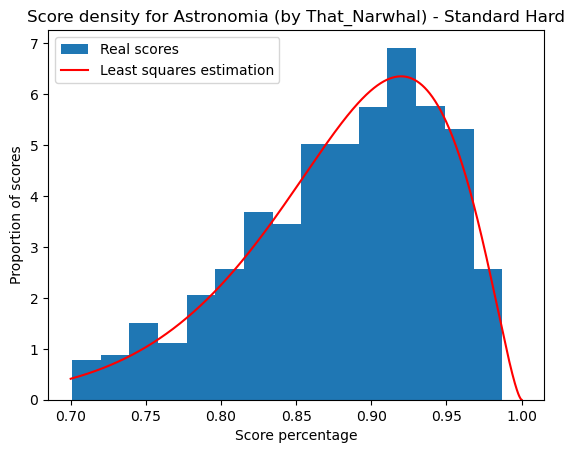

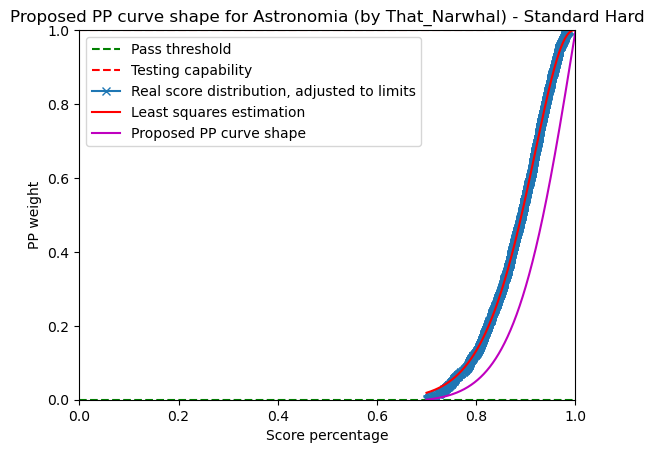

In [86]:
map_summary(best_r_squared_map_id)

{'Hash': '5868546dd2a98e6f0bc288a83506eb766113a9eb', 'Name': 'Forever', 'CoverImage': 'https://eu.cdn.beatsaver.com/5868546dd2a98e6f0bc288a83506eb766113a9eb.jpg', 'Mapper': 'Teuflum & muffn', 'Id': '1a56811', 'SongId': '1a568', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 4.844245, 'PassRating': 0.6914607, 'TechRating': 0.84012985, 'PredictedAcc': 0.9907359, 'ModifiersRating': {'Id': 7059, 'SSPredictedAcc': 0.9913616, 'SSPassRating': 0.52257466, 'SSAccRating': 4.582884, 'SSTechRating': 0.65259993, 'SSStars': 2.3211396, 'FSPredictedAcc': 0.9895627, 'FSPassRating': 0.93920034, 'FSAccRating': 5.305849, 'FSTechRating': 1.0966369, 'FSStars': 2.9676778, 'SFPredictedAcc': 0.987923, 'SFPassRating': 1.3487837, 'SFAccRating': 5.9963307, 'SFTechRating': 1.4765091, 'SFStars': 3.601074, 'BFSPredictedAcc': 0.99013305, 'BFSPassRating': 0.96056956, 'BFSAccRating': 4.680378, 'BFSTechRating': 1.117777, 'BFSStars': 2.565622, 'BSFPredictedAcc': 0.9889618, 'BSFPassRating': 1.3791386, 'BSF

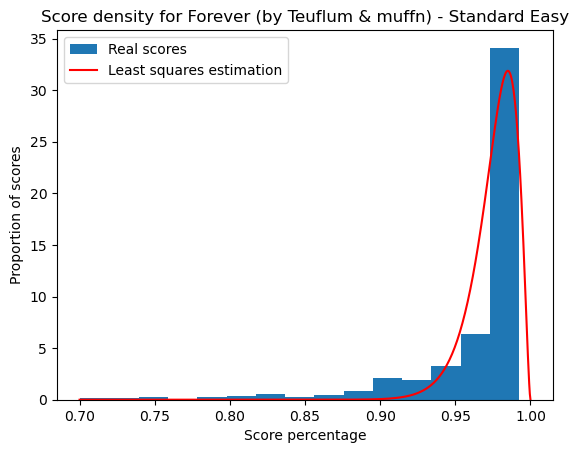

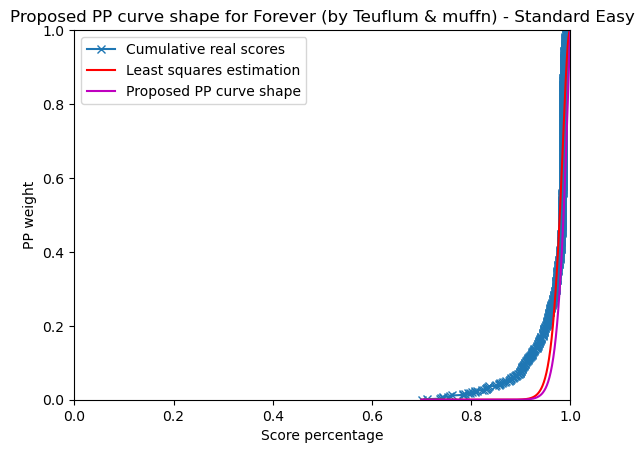

In [74]:
map_summary(worst_r_squared_map_id)

{'Hash': 'C200AD858AFF7C2AC0127616E3221497F5E82CF0', 'Name': 'Halo Reach - Lone Wolf', 'CoverImage': 'https://eu.cdn.beatsaver.com/c200ad858aff7c2ac0127616e3221497f5e82cf0.jpg', 'Mapper': 'Sp234', 'Id': '2812fxx31', 'SongId': '2812fxx', 'ModeName': 'Standard', 'DifficultyName': 'Normal', 'AccRating': 4.308947, 'PassRating': 0.71184963, 'TechRating': 0.7534237, 'PredictedAcc': 0.99131143, 'ModifiersRating': {'Id': 10149, 'SSPredictedAcc': 0.9919358, 'SSPassRating': 0.53735805, 'SSAccRating': 4.08792, 'SSTechRating': 0.5850832, 'SSStars': 2.011176, 'FSPredictedAcc': 0.9904466, 'FSPassRating': 0.96821284, 'FSAccRating': 4.657745, 'FSTechRating': 0.9834949, 'FSStars': 2.5375733, 'SFPredictedAcc': 0.9891225, 'SFPassRating': 1.3927765, 'SFAccRating': 5.125539, 'SFTechRating': 1.3234586, 'SFStars': 2.9989188, 'BFSPredictedAcc': 0.99084526, 'BFSPassRating': 0.98629063, 'BFSAccRating': 4.4004793, 'BFSTechRating': 0.99898183, 'BFSStars': 2.3799057, 'BSFPredictedAcc': 0.9899094, 'BSFPassRating': 

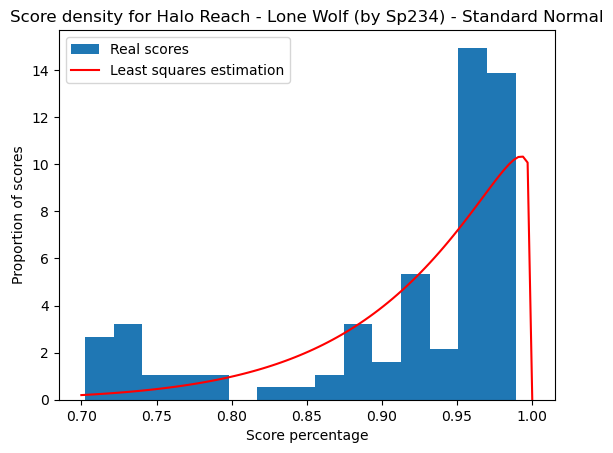

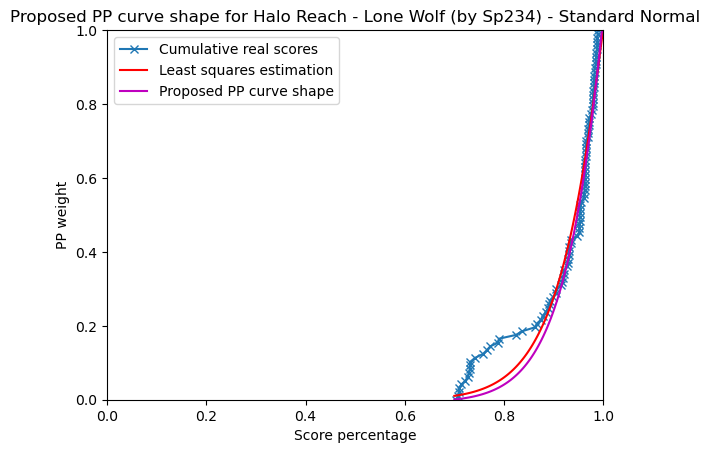

In [75]:
map_summary(worst_quantile_map_id)

In [ ]:
# Some well known maps
golden_standard_map_ids = ["c32d91","2ee3bxxxxxx91","7e8f11","36bce91","1f6b1xxxxxxxx91","23596xxx91","2cf6391","3e2c2xxxxx91","3bcf5xxxxxxxx91"]

for map_id in golden_standard_map_ids:
    map_summary(map_id)

## Dirty testing

In [ ]:
filtered_scores[25000]

In [ ]:
list(scores_by_map_id["1e0b511"].values())[0]

In [ ]:
len(score_data_by_map_id["7b3031"])

In [ ]:
a1, b1, loc1, scale1 = beta.fit(score_data_by_map_id["1e0b511"], floc=0, fscale=1)

print(a1,b1,loc1,scale1)

In [49]:
pp_curve_integral(0.995,(19.43,1.95,0,1))

0.9452827486918033

In [ ]:
xx = numpy.linspace(min_score,1,50)
print(plot_pp_curve_integral(xx,(20.02,2.795)))

In [ ]:
beta_parameters_per_map["1695b31"]

In [ ]:
maps_by_id["1695b31"]

In [ ]:
residuals(beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"])

In [ ]:
show_map_distribution_by_map_id("1695b31")

In [ ]:
random_map_summary()

In [ ]:
fit_scores_beta_least_squares(score_data_by_map_id["1695b31"],beta_parameters_per_map["1695b31"])

In [ ]:
r_squared_beta(least_squares_beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"])

In [ ]:
quantiles_beta(least_squares_beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"],10)

In [ ]:
print(best_r_squared_map_id)
print(best_r_squared)

In [ ]:
map_summary("e2ba51")

In [ ]:
a = [1,2,3,4,5]
print(list(zip(a[:-1],a[1:])))

In [ ]:
print(worst_r_squared_map_id)
print(worst_r_squared)

{'Hash': '5868546dd2a98e6f0bc288a83506eb766113a9eb', 'Name': 'Forever', 'CoverImage': 'https://eu.cdn.beatsaver.com/5868546dd2a98e6f0bc288a83506eb766113a9eb.jpg', 'Mapper': 'Teuflum & muffn', 'Id': '1a56811', 'SongId': '1a568', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 4.844245, 'PassRating': 0.6914607, 'TechRating': 0.84012985, 'PredictedAcc': 0.9907359, 'ModifiersRating': {'Id': 7059, 'SSPredictedAcc': 0.9913616, 'SSPassRating': 0.52257466, 'SSAccRating': 4.582884, 'SSTechRating': 0.65259993, 'SSStars': 2.3211396, 'FSPredictedAcc': 0.9895627, 'FSPassRating': 0.93920034, 'FSAccRating': 5.305849, 'FSTechRating': 1.0966369, 'FSStars': 2.9676778, 'SFPredictedAcc': 0.987923, 'SFPassRating': 1.3487837, 'SFAccRating': 5.9963307, 'SFTechRating': 1.4765091, 'SFStars': 3.601074, 'BFSPredictedAcc': 0.99013305, 'BFSPassRating': 0.96056956, 'BFSAccRating': 4.680378, 'BFSTechRating': 1.117777, 'BFSStars': 2.565622, 'BSFPredictedAcc': 0.9889618, 'BSFPassRating': 1.3791386, 'BSF

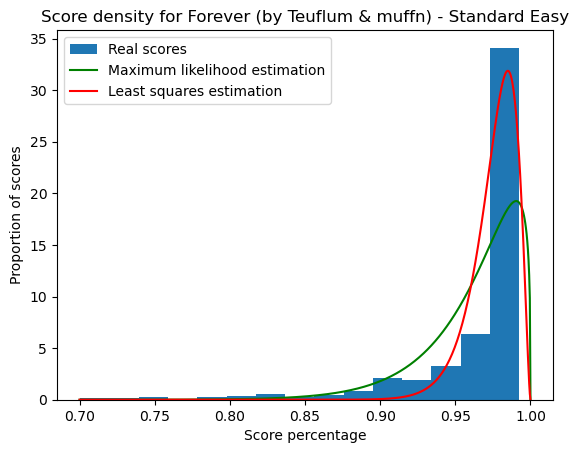

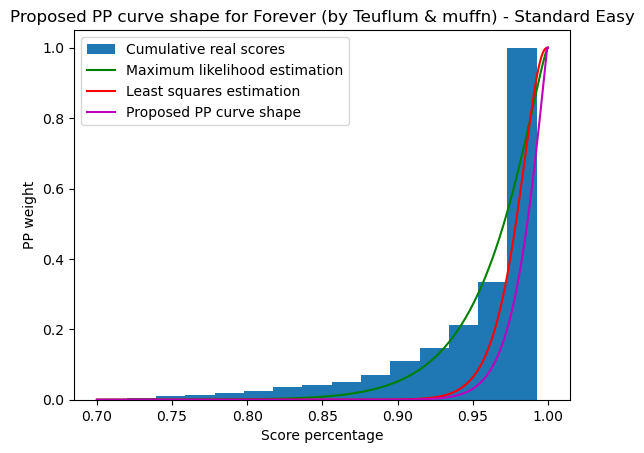

In [30]:
map_summary("1a56811")

{'Hash': 'ed1a3273b99d5f0b0cd61a1d42cbe02de11fe0c8', 'Name': 'Scream', 'CoverImage': 'https://na.cdn.beatsaver.com/ed1a3273b99d5f0b0cd61a1d42cbe02de11fe0c8.jpg', 'Mapper': 'Serephor, CMP1111, LaidBackAries', 'Id': '38419x91', 'SongId': '38419x', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 10.3140135, 'PassRating': 3.5834234, 'TechRating': 8.042309, 'PredictedAcc': 0.9753135, 'ModifiersRating': {'Id': 1132570, 'SSPredictedAcc': 0.97667176, 'SSPassRating': 2.872866, 'SSAccRating': 9.854296, 'SSTechRating': 7.1137333, 'SSStars': 7.7946877, 'FSPredictedAcc': 0.97369045, 'FSPassRating': 4.5441246, 'FSAccRating': 10.775066, 'FSTechRating': 8.991936, 'FSStars': 9.382673, 'SFPredictedAcc': 0.97149974, 'SFPassRating': 6.08231, 'SFAccRating': 11.372445, 'SFTechRating': 10.10108, 'SFStars': 10.586478, 'BFSPredictedAcc': 0.9745814, 'BFSPassRating': 4.6645627, 'BFSAccRating': 10.261094, 'BFSTechRating': 9.076766, 'BFSStars': 8.988707, 'BSFPredictedAcc': 0.9710023, 'BSFPassR

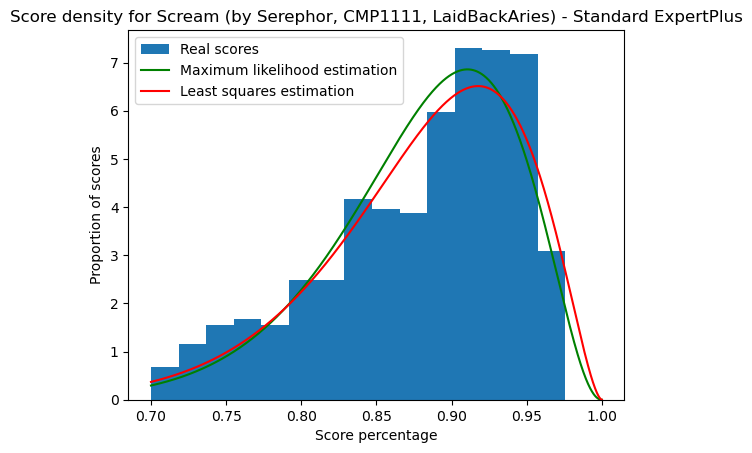

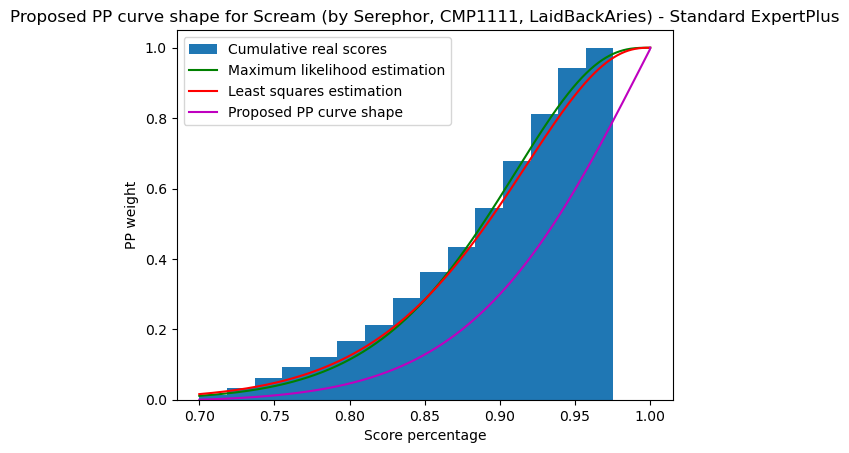

In [34]:
map_summary("38419x91")

(33.410241774553185, 1.3118459093913721)
(23.72377370446156, 1.0275556306842777, 0.22400148402810405, 0.8803916744987221)


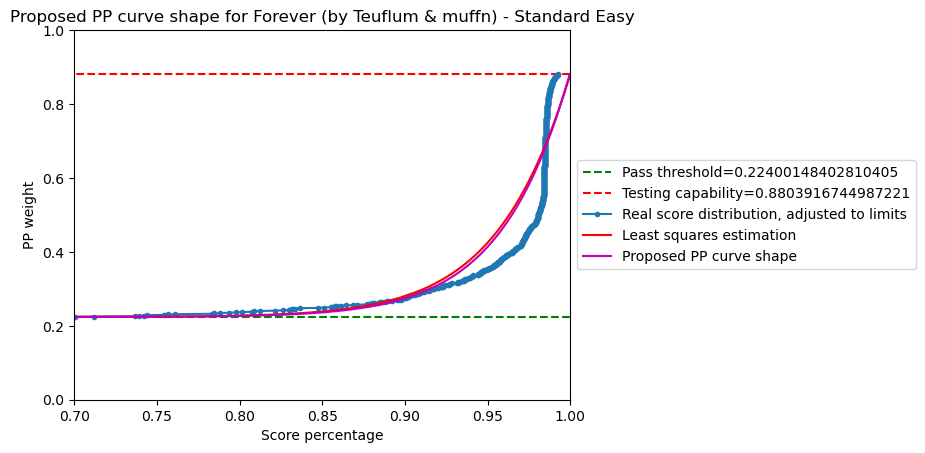

r2 = 0.7631994772055838


In [184]:
def testy_test(map_id):
    (a,b) = beta_parameters_per_map[map_id]
    scores = score_data_by_map_id[map_id]
    #scores_with_skills = [(score,0.5) for score in scores]
    #scores_with_skills = [(score,score+random.random()/50) for score in scores]
    #scores_with_skills = [(score,1-2*(1-score)+random.random()/10) for score in scores]
    #scores_with_skills = [(score,0.5+0.5*beta.cdf(score,a,b)) for score in scores]
    scores_with_skills = [(score,0.1+0.6*beta.cdf(score,a,b)+0.3*random.random()) for score in scores]
    print((a,b))
    pass_threshold = 0
    testing_capability = 1
    initial_params = (a,b,pass_threshold,testing_capability)
    
    
    (a,b,pass_threshold,testing_capability) = fit_scores_beta_least_squares_affine_skills(scores_with_skills, initial_params)
    
    print((a,b,pass_threshold,testing_capability))
    show_map_distribution(maps_by_id[map_id], scores, a, b, pass_threshold, testing_capability)
    print(f"r2 = {r_squared_beta_affine_skills((a,b,pass_threshold,testing_capability),scores_with_skills)}")
    #print(residuals_affine_skills((a,b,pass_threshold,testing_capability),scores_with_skills))

map_id = worst_r_squared_map_id
testy_test(map_id)


#golden_standard_map_ids = ["c32d91","2ee3bxxxxxx91","7e8f11","36bce91","1f6b1xxxxxxxx91","23596xxx91","2cf6391","3e2c2xxxxx91","3bcf5xxxxxxxx91"]

#for map_id in golden_standard_map_ids:
#    testy_test(map_id)

array([-0.17919337,  0.18742111, -0.03648072, ...,  0.30297428,
        0.1830439 , -0.58053261])